In [1]:
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pickle

In [2]:
# Define the network SISD function
def network_SISD(g, N, beta_1, beta_2, beta_3, gamma, delta, mu, S0, I0, max_time):
    pop_size = S0 + I0
    
    i_nodes = list(range(N))
    for i in range(N):
        i_node = random.choice(i_nodes)
        i_nodes.remove(i_node)

        if (i < math.floor(S0/pop_size * N)):
            g.nodes[i_node]['state'] = 'S'
        else:
            g.nodes[i_node]['state'] = 'I1'

    S = len([x for x,y in g.nodes(data=True) if y['state']=='S'])
    I1 = len([x for x,y in g.nodes(data=True) if y['state']=='I1'])
    I2 = len([x for x,y in g.nodes(data=True) if y['state']=='I2'])
    I3 = len([x for x,y in g.nodes(data=True) if y['state']=='I3'])
    D = len([x for x,y in g.nodes(data=True) if y['state']=='D'])
    states = [(0, S/N, I1/N, I2/N, I3/N, D/N)]

    strain_2_time = None
    strain_3_time = None
    S_at_2, I1_at_2, = None, None
    S_at_3, I1_at_3, I2_at_3 = None, None, None

    for t in range(max_time):
        for node in g.nodes():
            all_neighbors = list(g.neighbors(node))
            neighbors = [n for n in all_neighbors if g.nodes[n]['state'] != 'D']
            if neighbors:
                contact = random.choice(neighbors)
            else:
                contact = None
            if g.nodes[node]['state'] == 'S':
                if contact is not None:
                    if (g.nodes[contact]['state'] == 'I1'):
                        if random.random() < beta_1:
                            g.nodes[node]['state'] = 'I1'
                            S -= 1
                            I1 += 1
                    elif (g.nodes[contact]['state'] == 'I2'):
                        if random.random() < beta_2:
                            g.nodes[node]['state'] = 'I2'
                            S -= 1
                            I2 += 1
                    elif (g.nodes[contact]['state'] == 'I3'):
                        if random.random() < beta_3:
                            g.nodes[node]['state'] = 'I3'
                            S -= 1
                            I3 += 1
            elif g.nodes[node]['state'] == 'I1':
                if contact is not None:
                    if (g.nodes[contact]['state'] == 'I2'):
                        if random.random() < beta_2:
                            g.nodes[node]['state'] = 'I2'
                            I1 -= 1
                            I2 += 1
                    elif (g.nodes[contact]['state'] == 'I3'):
                        if random.random() < beta_3:
                            g.nodes[node]['state'] = 'I3'
                            I1 -= 1
                            I3 += 1
                    elif random.random() < gamma:
                        g.nodes[node]['state'] = 'S'
                        I1 -= 1
                        S += 1
                    elif random.random() < delta:
                        g.nodes[node]['state'] = 'D'
                        I1 -= 1
                        D += 1
                    elif random.random() < mu:
                        g.nodes[node]['state'] = 'I2'
                        I1 -= 1
                        I2 += 1
                else:
                    if random.random() < gamma:
                        g.nodes[node]['state'] = 'S'
                        I1 -= 1
                        S += 1
                    elif random.random() < delta:
                        g.nodes[node]['state'] = 'D'
                        I1 -= 1
                        D += 1
                    elif random.random() < mu:
                        g.nodes[node]['state'] = 'I2'
                        I1 -= 1
                        I2 += 1
            elif g.nodes[node]['state'] == 'I2':
                if contact is not None:
                    if (g.nodes[contact]['state'] == 'I1'):
                        if random.random() < beta_1:
                            g.nodes[node]['state'] = 'I1'
                            I2 -= 1
                            I1 += 1
                    elif (g.nodes[contact]['state'] == 'I3'):
                        if random.random() < beta_3:
                            g.nodes[node]['state'] = 'I3'
                            I2 -= 1
                            I3 += 1
                    elif random.random() < gamma:
                        g.nodes[node]['state'] = 'S'
                        I2 -= 1
                        S += 1
                    elif random.random() < delta:
                        g.nodes[node]['state'] = 'D'
                        I2 -= 1
                        D += 1
                    elif random.random() < mu:
                        g.nodes[node]['state'] = 'I3'
                        I2 -= 1
                        I3 += 1
                else:
                    if random.random() < gamma:
                        g.nodes[node]['state'] = 'S'
                        I2 -= 1
                        S += 1
                    elif random.random() < delta:
                        g.nodes[node]['state'] = 'D'
                        I2 -= 1
                        D += 1
                    elif random.random() < mu:
                        g.nodes[node]['state'] = 'I3'
                        I2 -= 1
                        I3 += 1
            elif g.nodes[node]['state'] == 'I3':
                if contact is not None:
                    if (g.nodes[contact]['state'] == 'I1'):
                        if random.random() < beta_1:
                            g.nodes[node]['state'] = 'I1'
                            I3 -= 1
                            I1 += 1
                    elif (g.nodes[contact]['state'] == 'I2'):
                        if random.random() < beta_2:
                            g.nodes[node]['state'] = 'I2'
                            I3 -= 1
                            I2 += 1
                    elif random.random() < gamma:
                        g.nodes[node]['state'] = 'S'
                        I3 -= 1
                        S += 1
                    elif random.random() < delta:
                        g.nodes[node]['state'] = 'D'
                        I3 -= 1
                        D += 1
                else:
                    if random.random() < gamma:
                        g.nodes[node]['state'] = 'S'
                        I3 -= 1
                        S += 1
                    elif random.random() < delta:
                        g.nodes[node]['state'] = 'D'
                        I3 -= 1
                        D += 1
        states.append((t+1, S/N, I1/N, I2/N, I3/N, D/N))
    
        if strain_2_time is None and I2 > 0:
            strain_2_time = t
            S_at_2 = S
            I1_at_2 = I1
        if strain_3_time is None and I3 > 0:
            strain_3_time = t
            S_at_3 = S
            I1_at_3 = I1
            I2_at_3 = I2

    if strain_2_time is None:
        R0_2 = 0
    else:
        R0_2 = (mu * I1_at_2 + beta_2 * (S_at_2 + I1_at_2 )/ N) / ((beta_1 * I1_at_2 / N )+ delta + gamma + mu)
    if strain_3_time is None:
        R0_3=0
    else:
        R0_3 = (mu * I2_at_3 + beta_3 * (S_at_3 + I2_at_3 + I1_at_3) / N) / ((beta_2 * I2_at_3 / N )+ (beta_1 * I1_at_3 / N) + delta + gamma)

    return states, R0_2, R0_3

In [12]:

# Beta values to test
beta_1_values = np.arange(0.07, 0.16, 0.01)


networks = ["hetero_cc_0.05", "hetero_cc_0.5", "hetero_cc_0.34","hetero_deg_var_4.46", "hetero_deg_var_8.76", "hetero_deg_var_30.35","homog_regular"]

# Store data for contour plots
r0_eff_1_data = []
epidemic_size_data = []
peak_infection_data = []
percolation_thresholds = []

# Store intermediate results
intermediate_results = []

for network in networks:
    path = "/Users/rohinijanivara/Documents/Academics/Data Science for Epidemiology/Project/networks/"
    header = os.path.join(path, f"{network}.txt")
    G = nx.read_edgelist(header)

    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    n_nodes = G.number_of_nodes()

    degrees = [d for n, d in G.degree()]
    first_moment = sum(degrees) / len(degrees)
    second_moment = sum(d**2 for d in degrees) / len(degrees)

    if ("homog" in network):
        lambda_c = 1 / first_moment
    else:
        lambda_c = first_moment / (second_moment - first_moment)

    # Temporary lists to store data for each network and beta_1
    r0_eff_1_list = []
    epidemic_size_list = []
    peak_infection_list = []
    percolation_threshold_list = []

    for beta_1 in beta_1_values:
        beta_2 = beta_1 * 9 / 8
        beta_3 = beta_2 * 10 / 9
        gamma = 0.05
        delta = 0.0005
        mu = 0.0005
        I0 = 0.05
        S0 = 1 - I0
        max_time = 1000
        runs = 5

        cumulative_S = np.zeros(max_time + 1)
        cumulative_I1 = np.zeros(max_time + 1)
        cumulative_I2 = np.zeros(max_time + 1)
        cumulative_I3 = np.zeros(max_time + 1)
        cumulative_D = np.zeros(max_time + 1)

        for i in tqdm(range(runs)):
            results, R0_2, R0_3 = network_SISD(G, n_nodes, beta_1, beta_2, beta_3, gamma, delta, mu, S0, I0, max_time)
            t, S, I1, I2, I3, D = zip(*results)

            cumulative_S = np.add(cumulative_S, S)
            cumulative_I1 = np.add(cumulative_I1, I1)
            cumulative_I2 = np.add(cumulative_I2, I2)
            cumulative_I3 = np.add(cumulative_I3, I3)
            cumulative_D = np.add(cumulative_D, D)

        average_S = cumulative_S / runs
        average_I1 = cumulative_I1 / runs
        average_I2 = cumulative_I2 / runs
        average_I3 = cumulative_I3 / runs

        R0_1 = beta_1 / (delta + gamma + mu)
        per_1 = beta_1 / R0_1

        r0_eff_1 = R0_1 / lambda_c
        epidemic_size = 1 - average_S[max_time]
        peak_infection = max(average_I1 + average_I2 + average_I3)

        # Store the results for each beta_1
        r0_eff_1_list.append(r0_eff_1)
        epidemic_size_list.append(epidemic_size)
        peak_infection_list.append(peak_infection)
        percolation_threshold_list.append(per_1 * lambda_c)

        # Store intermediate results
        intermediate_results.append({
            'network': network,
            'beta_1': beta_1,
            'r0_eff_1': r0_eff_1,
            'epidemic_size': epidemic_size,
            'peak_infection': peak_infection,
            'percolation_threshold': per_1 * lambda_c
        })

    # Append data for the current network
    r0_eff_1_data.append(r0_eff_1_list)
    epidemic_size_data.append(epidemic_size_list)
    peak_infection_data.append(peak_infection_list)
    percolation_thresholds.append(percolation_threshold_list)

# Save intermediate results to a file
with open('intermediate_results.pkl', 'wb') as f:
    pickle.dump(intermediate_results, f)

100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


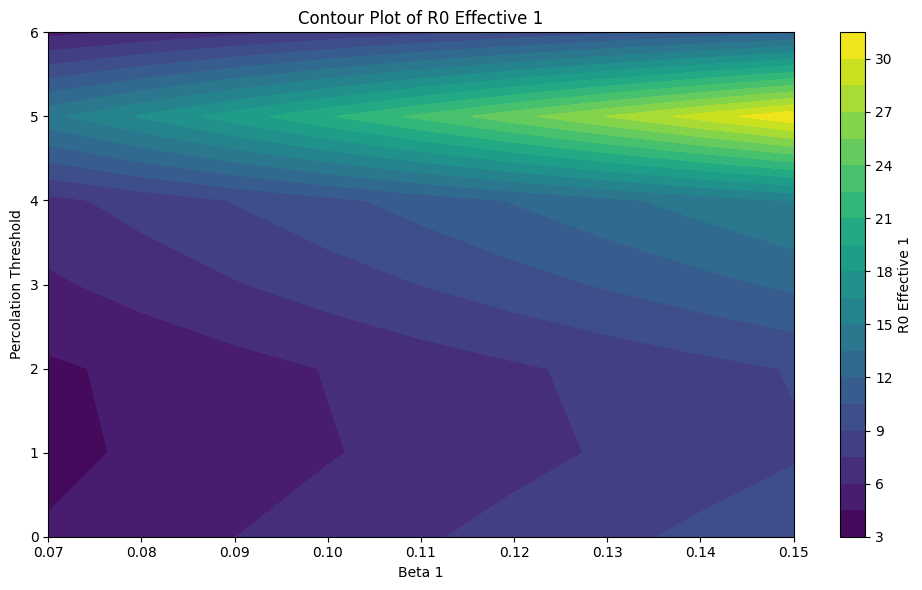

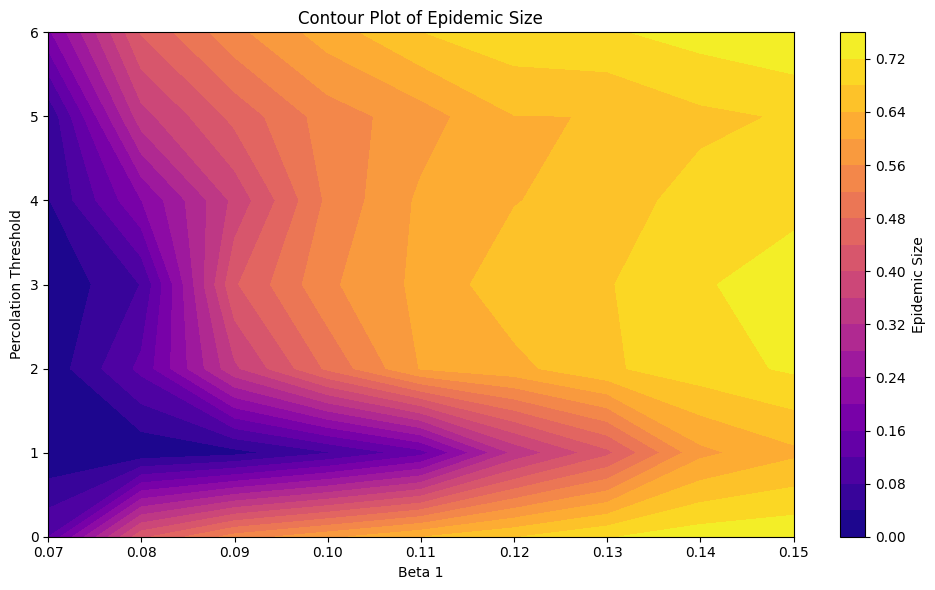

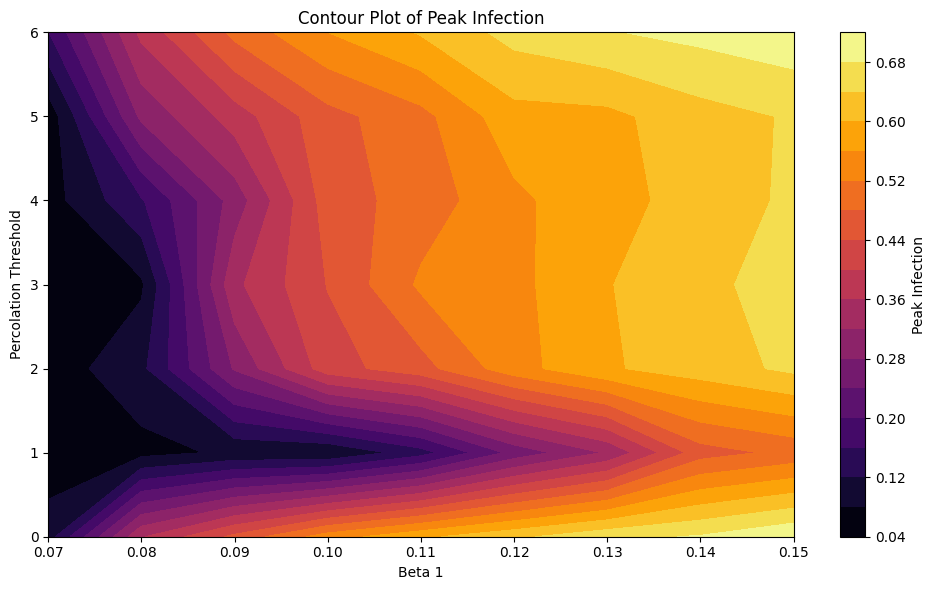

In [14]:
# Convert lists to numpy arrays for plotting
r0_eff_1_data = np.array(r0_eff_1_data)
epidemic_size_data = np.array(epidemic_size_data)
peak_infection_data = np.array(peak_infection_data)
percolation_thresholds = np.array(percolation_thresholds)

# Generate contour plots
X, Y = np.meshgrid(beta_1_values, range(len(networks)))

# Ensure the data dimensions are consistent for contour plotting
assert r0_eff_1_data.shape == (len(networks), len(beta_1_values))
assert epidemic_size_data.shape == (len(networks), len(beta_1_values))
assert peak_infection_data.shape == (len(networks), len(beta_1_values))
assert percolation_thresholds.shape == (len(networks), len(beta_1_values))

# Plot for r0_eff_1
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, r0_eff_1_data, levels=20, cmap='viridis')
plt.colorbar(label='R0 Effective 1')
plt.xlabel('Beta 1', size=15)
plt.ylabel('Percolation Threshold', size=15)
plt.title('Contour Plot of R0 Effective 1')
plt.tight_layout()
plt.savefig('contour_r0_eff_1.png')
plt.show()

# Plot for Epidemic Size
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, epidemic_size_data, levels=20, cmap='plasma')
plt.colorbar(label='Epidemic Size')
plt.xlabel('Beta 1', size=15)
plt.ylabel('Percolation Threshold', size=15)
plt.title('Contour Plot of Epidemic Size')
plt.tight_layout()
plt.savefig('contour_epidemic_size.png')
plt.show()

# Plot for Peak Infection
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, peak_infection_data, levels=20, cmap='inferno')
plt.colorbar(label='Peak Infection')
plt.xlabel('Beta 1', size=15)
plt.ylabel('Percolation Threshold', size=15)
plt.title('Contour Plot of Peak Infection')
plt.tight_layout()
plt.savefig('contour_peak_infection.png')
plt.show()
